<a href="https://colab.research.google.com/github/dscohen75/DS-Unit-2-Linear-Models/blob/master/module2-regression-2/LS_DS_212_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [16]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [22]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv', index_col='created')
#assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

### Not sure why the number of rows has changed, but I was getting an error until I commented out the assert statement.

In [23]:
df.shape

(48817, 33)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48817 entries, 2016-06-24 07:54:24 to 2016-04-12 02:48:07
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bathrooms             48817 non-null  float64
 1   bedrooms              48817 non-null  int64  
 2   description           47392 non-null  object 
 3   display_address       48684 non-null  object 
 4   latitude              48817 non-null  float64
 5   longitude             48817 non-null  float64
 6   price                 48817 non-null  int64  
 7   street_address        48807 non-null  object 
 8   interest_level        48817 non-null  object 
 9   elevator              48817 non-null  int64  
 10  cats_allowed          48817 non-null  int64  
 11  hardwood_floors       48817 non-null  int64  
 12  dogs_allowed          48817 non-null  int64  
 13  doorman               48817 non-null  int64  
 14  dishwasher            48817 non-null  int64

In [34]:
df.head()

,bathrooms,bedrooms,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-24 07:54:24,1.5,3,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-06-12 12:19:27,1.0,2,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-17 03:26:41,1.0,1,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-18 02:22:02,1.0,1,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-28 01:32:41,1.0,4,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
df.index = pd.to_datetime(df.index, infer_datetime_format=True)

In [ ]:
df.info()

Split the original dataframe frist into time periods for training and validation.

In [36]:
train_start = '04-01-2016'
train_end = '05-31-2016'
val_start = '06-01-2016'
val_end = '06-30-2016'

mask = (df.index > train_start) & (df.index <= train_end)

df_train = df.loc[mask]

df_val = df.loc[~mask]

Split each of these train and val sets into target and feature matrix.

In [37]:
y_train = df_train['price']
X_train = df_train[['bedrooms', 'bathrooms']]

In [41]:
y_train.shape

(31839,)

In [42]:
X_train.shape

(31839, 2)

In [38]:
y_val = df_val['price']
X_val = df_val[['bedrooms', 'bathrooms']]

In [39]:
y_train.head()

created
2016-04-17 03:26:41    2850
2016-04-18 02:22:02    3275
2016-04-28 01:32:41    3350
2016-04-19 04:24:47    7995
2016-04-27 03:19:56    3600
Name: price, dtype: int64

In [40]:
X_train.head()

,bedrooms,bathrooms
created,,
2016-04-17 03:26:41,1,1.0
2016-04-18 02:22:02,1,1.0
2016-04-28 01:32:41,4,1.0
2016-04-19 04:24:47,4,2.0
2016-04-27 03:19:56,2,1.0


Establish baseline

In [47]:
y_pred_base = [y_train.mean()]*len(y_train)

In [48]:
from sklearn.metrics import mean_absolute_error

print('Baseline MAE', mean_absolute_error(y_train, y_pred_base))

Baseline MAE 1201.9731808995773


Build a model with one feature only, say bedrooms.

In [45]:
from sklearn.linear_model import LinearRegression

In [95]:
#1 Instantiate
model = LinearRegression()

#2 Fit model to data
model.fit(X_train[['bedrooms']], y_train)

#3 Make predictions

y_pred = model.predict(X_train[['bedrooms']])

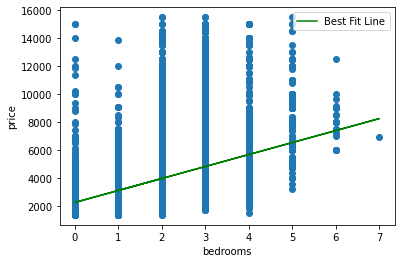

In [56]:
import matplotlib.pyplot as plt
  
plt.scatter(X_train['bedrooms'], y_train)
plt.plot(X_train['bedrooms'], y_pred, color='green', label='Best Fit Line')
plt.xlabel('bedrooms')
plt.ylabel('price')
plt.legend();

In [98]:
print('Training R2:', model.score(X_train[['bedrooms']], y_train))
print('Validation R2', model.score(X_val[['bedrooms']], y_val))

Training R2: 0.28794110634694325
Validation R2 0.28451797751532604


-  Engineer at least two new features. 
-  Fit a linear regression model with at least two features.
-  Get the model's coefficients and intercept.
-  Get regression metrics RMSE, MAE, and  𝑅2 , for both the train and test data.


In [86]:
df['cats_allowed']

created
2016-06-24 07:54:24    0
2016-06-12 12:19:27    1
2016-04-17 03:26:41    0
2016-04-18 02:22:02    0
2016-04-28 01:32:41    0
                      ..
2016-06-02 05:41:05    0
2016-04-04 18:22:34    1
2016-04-16 02:13:40    1
2016-04-08 02:13:33    1
2016-04-12 02:48:07    0
Name: cats_allowed, Length: 48817, dtype: int64

In [89]:
df['all_pets'] = (df['cats_allowed'] & df['dogs_allowed']).astype(int)

In [90]:
df[['cats_allowed'] + ['dogs_allowed'] + ['all_pets']]

,cats_allowed,dogs_allowed,all_pets
created,,,
2016-06-24 07:54:24,0,0,0
2016-06-12 12:19:27,1,1,1
2016-04-17 03:26:41,0,0,0
2016-04-18 02:22:02,0,0,0
2016-04-28 01:32:41,0,0,0
...,...,...,...
2016-06-02 05:41:05,0,0,0
2016-04-04 18:22:34,1,1,1
2016-04-16 02:13:40,1,1,1


In [66]:
df['total_rooms'] = df['bedrooms'] + df['bathrooms']

In [68]:
# Need to redefine df_train to include these new columns

df_train = df.loc[mask]

df_val = df.loc[~mask]

In [69]:
X_train2 = df_train[['total_rooms', 'all_pets']]
X_val2 = df_val[['total_rooms','all_pets']]

In [70]:
#1 Instantiate
model2 = LinearRegression()

#2 Fit model to data
model2.fit(X_train2, y_train)

#3 Make predictions

y_pred2 = model2.predict(X_train2)

In [71]:
model2.intercept_

1270.4566683999406

In [72]:
model2.coef_

array([809.52029135, 210.42381823])

MAE

In [76]:
print('Training MAE:', mean_absolute_error(y_train, model2.predict(X_train2)))
print('Validation MAE:', mean_absolute_error(y_val, model2.predict(X_val2)))

Training MAE: 887.6091205888804
Validation MAE: 905.0622442240528


In [77]:
from sklearn.metrics import mean_squared_error

In [78]:
print('Training RMSE:', mean_squared_error(y_train, model2.predict(X_train2), squared=False))
print('Validation RMSE:', mean_squared_error(y_val, model2.predict(X_val2), squared=False))

Training RMSE: 1336.796172277362
Validation RMSE: 1335.8346666619243


## $R^2$

In [83]:
print('Training R2:', model2.score(X_train2, y_train))
print('Validation R2', model2.score(X_val2, y_val))

Training R2: 0.42453715895600597
Validation R2 0.4257382827722005


This was a pretty big improvement over 'bedrooms' alone. Let's see how much better we can do by adding one more feature, laundry in unit:

In [91]:
X_train3 = df_train[['total_rooms', 'all_pets','laundry_in_unit']]
X_val3 = df_val[['total_rooms','all_pets','laundry_in_unit']]

In [92]:
#1 Instantiate
model3 = LinearRegression()

#2 Fit model to data
model3.fit(X_train3, y_train)

#3 Make predictions

y_pred3 = model3.predict(X_train3)

In [93]:
print('Training R2:', model3.score(X_train3, y_train))
print('Validation R2', model3.score(X_val3, y_val))

Training R2: 0.44927823646357073
Validation R2 0.4449116145041799


Laundry in unit is not an important selling point apparently.